In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


### Outline

- Outlier Analysis
- Forecasting horizon explained
- Time Series Cross Validation
- Lag Features
- Predicting the Future

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [4]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


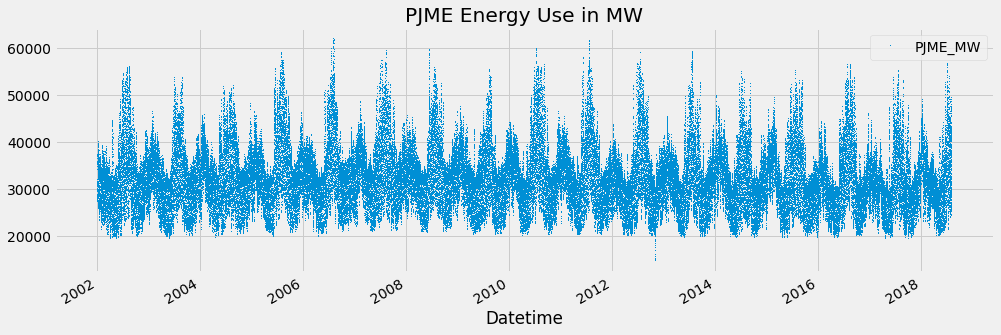

In [7]:
df.plot(style=',',
       figsize=(15,5),
       color=color_pal[0],
       title='PJME Energy Use in MW')
plt.show()

### 1. Outlier Analysis and Removal 

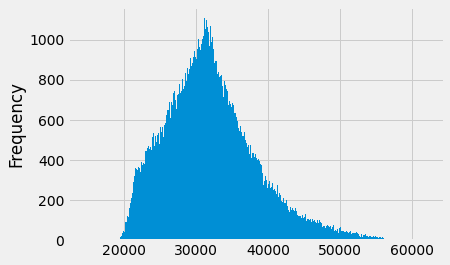

In [8]:
df['PJME_MW'].plot(kind='hist', bins=500);

<AxesSubplot:xlabel='Datetime'>

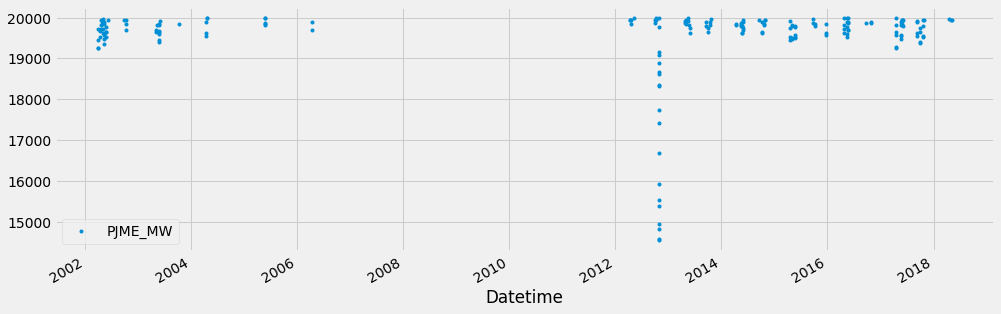

In [9]:
df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.') # outliers below 19000 do not look legitimate

<AxesSubplot:xlabel='Datetime'>

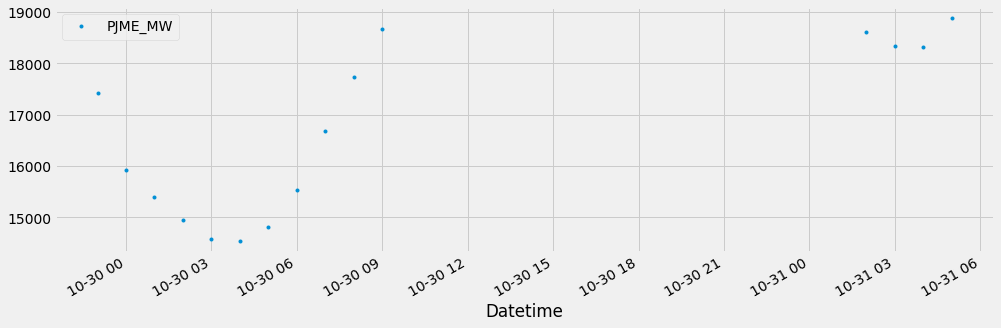

In [10]:
df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.') # closer look at the outliers that are below 19000

In [11]:
df = df.query('PJME_MW > 19_000').copy()

### Reviewing: Train/ Test Split

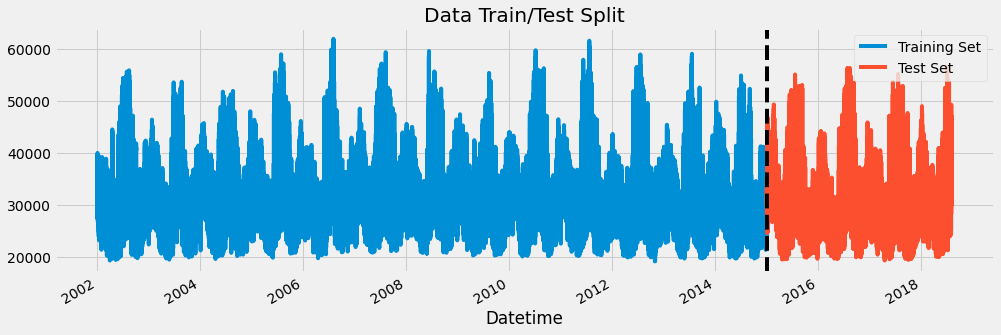

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title= 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### 2. Time Series Cross Validation

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size = 24*365*1, gap=24)
df = df.sort_index()

In [17]:
train_idx, val_idx

(array([     0,      1,      2, ..., 101524, 101525, 101526]),
 array([101551, 101552, 101553, ..., 110308, 110309, 110310]))

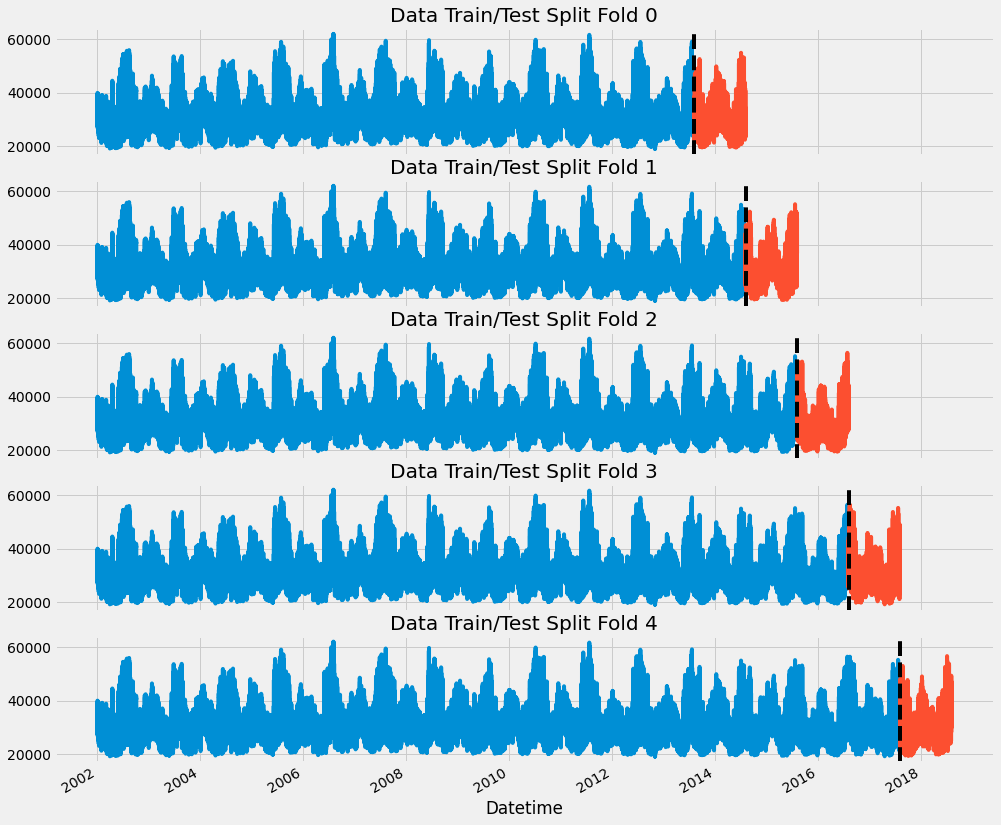

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(15,15),
                       sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], 
                          label='Training Set', 
                          title= f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], 
                         label='Test Set')
    axs[fold].axvline(test.index.min(), 
                      color='black', ls='--')
    fold += 1

### 3. Forecasting Horison Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons( less than three months) to long-term horizons (more than two years).

In [22]:
def create_features(df):    
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week # monday: 0, sunday: 6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### 3. Lag Features
- What was the target (x) days in the past.

In [27]:
def add_lags(df):    
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [28]:
df = add_lags(df)

In [31]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [33]:
### Train Using Cross Validation

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, 
                        booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train, 
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[18:52:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[18:52:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[400]	validation_0-rmse:3476.76871	validation_1-rmse:3598.75393
[500]	validation_0-rmse:3355.49568	validation_1-rmse:3

In [35]:
print(f'Scores across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Scores across folds 3753.5994
Fold scores: [3757.485267269142, 3422.628654218696, 3473.0621874794947, 4115.966281700851, 3998.8545666889618]


### 4. Prediction the future

- Retraining on all data
- To predict the future we need an empty dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [36]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, 
                    booster='gbtree',
                   n_estimators=500,
                   early_stopping_rounds=50,
                   objective='reg:squarederror',
                   max_depth=3,
                   learning_rate=0.01)
reg.fit(X_all, y_all, 
       eval_set=[(X_all, y_all)],
       verbose=100)

[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [40]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [45]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [46]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


### Predict the future

In [47]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

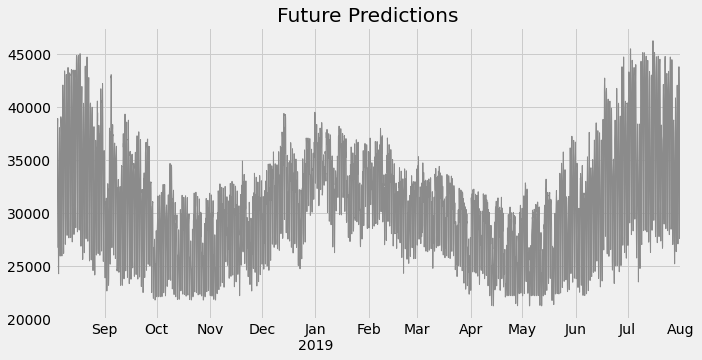

In [49]:
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[4],
                              ms=1,
                              lw=1,
                              title='Future Predictions')
plt.show()

### Save the model for further use

In [50]:
reg.save_model('model.json')

In [52]:
!ls -lh

total 576K
---------- 1 root root  263 Oct 18 17:44 __notebook_source__.ipynb
-rw-r--r-- 1 root root 572K Oct 18 19:19 model.json


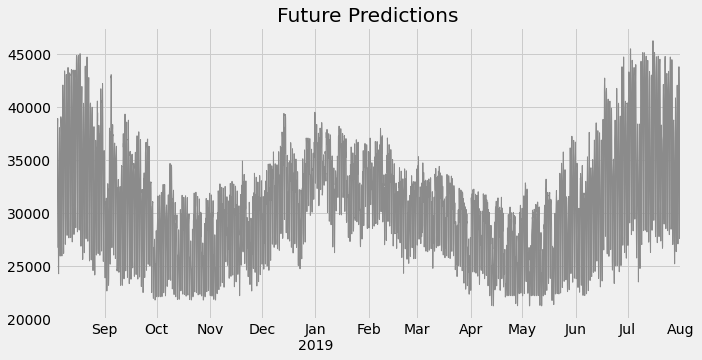

In [54]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[4],
                              ms=1,
                              lw=1,
                              title='Future Predictions')
plt.show()